# CoSP Assignment 3: Style Coordination

### Submission details:

* **Deadline: Wednesday 22/11/2017 at 20:00** Please submit your work on time. Late submissions will not be graded.
* You can do the assignment either individually, or in a group of 2 people.
* Submit the .ipynb file containing your code **via email to nadine.theiler@uva.nl using "[CoSP17] Assignment 3" as a subject line**. Rename the .ipynb file so that the file name contains your last name(s), e.g. assignment3_ntheiler.ipynb. If you submit your answers as a group, clearly indicate this in the name of the file, and preferably also in the comment section.
* For every question, it is indicated how many points you can maximally get for it. The total number of points for the assignment is 100. The assignment also contains a bonus question for which you can get 10 points.

### Some technical remarks:
* You should write your code and answers **in this Jupyter notebook**. The blocks for code and text are already created, just click on them and change the content.
* Make sure we can run the notebook. If you can run your notebook from the folder *cosp2017_practical* you downloaded during the introductory practical session without modifications, then your setup should be ok and we should be able to run your notebook too. 
* If you want to run a particular cell in the notebook, make sure you also run the cells above it that it depends on.
* Make sure to put "%pylab inline" somewhere in the beginning of your notebook, such that plots will appear inline.

In [1]:
# imports
%matplotlib inline
from swda_time import CorpusReader
from swda_time import Transcript
import matplotlib.pyplot as plt
import numpy as np

## Coordination

In this assignment we will explore style coordination between two speakers in a conversation. We will use the linguistic coordination measure proposed by Danescu-Niculescu-Mizil et al. (2012), which is based on the common occurrence of linguistic markers (types of function words, such as quantifiers or prepositions). The authors define the coordination of speaker B towards speaker A with respect to some marker $m$ as the conditional probability that a turn by speaker B contains a certain linguistic marker $m$ given that speaker A used this marker in the previous turn, minus the overall probability that speaker B uses this marker in any turn:

$C^m(B,A) = P(T^m_B|T^m_A) - P(T^m_B)$

Where $P(T^m_B|T^m_A)$ denotes the probability that speaker B uses marker $m$ in a turn immediately following a turn in which speaker A used this marker. All probabilities are estimated using relative frequency estimation from the corpus counts. 

The linguistic style markers used by Danescu-Niculescu-Mizil et al. are 8 categories of words: articles, auxiliary verbs, conjunctions, high-frequency adverbs, impersonal pronouns, personal pronouns, prepositions, and quantifiers. An utterance or turn is said to exhibit a certain marker $m$ if it contains a word from a list of words associated with this marker. 

In this assignment you will use the lists of markers compiled by Noble & Fernández (2015), available in the file *markers.py* which you find in the folder *cosp2017_practical*.

**References**

C. Danescu-Niculescu-Mizil, L. Lee, B. Pang and J. Kleinberg (2012). Echoes of power: Language effects and power differences in social interaction, in Proceedings of WWW. [http://www.cs.cornell.edu/~cristian/Echoes_of_power.html]

B. Noble and R. Fernández (2015). Center stage: How social network position shapes linguistic coordination, in Proceedings of CMCL. [http://www.aclweb.org/anthology/W15-1104.pdf]

In [2]:
from markers import *
print prepositions

['of', 'in', 'to', 'for', 'with', 'on', 'by', 'at', 'from', 'as', 'into', 'about', 'like', 'after', 'between', 'through', 'over', 'against', 'under', 'out of', 'without', 'within', 'during', 'before', 'such as', 'towards', 'around', 'upon', 'including', 'among', 'across', 'off', 'behind', 'since', 'because of', 'as well as', 'rather than', 'until', 'according to', 'up to', 'despite', 'near', 'above', 'per', 'along', 'away from', 'throughout', 'outside', 'round', 'beyond', 'worth', 'in terms of', 'down', 'on to', 'up', 'due to', 'inside', 'as to', 'instead of', 'plus']


## Collecting frequency information

To compute the amount of coordination within a conversation, we will have to do some frequency counting. We provide a (rather long) function that you can use to do all the counting in one iteration through a transcript (to prevent looping through the transcript multiple times). Given as input a list or set with marker words and a Transcript object, the function computes: 

* the number of turns per speaker, 
* the baseline occurence of markers in the turns of both speaker A and B, and 
* the number of times the occurence of the use of a marker in a turn of speaker A followed the use of a marker in a consecutive turn of speaker B. 

These three counts are stored in three dictionaries called `turns`, `markers` and `markers_conditional`, respectively, with the speakers as keys and the counts as values. Entry `markers_conditional(B)` contains the counts C(m in B|m in A), where B's turn was following the turn of A. Utterances tagged as backchannels and fragments are ignored when computing the turns.

In [3]:
def get_frequency_info(marker_words, transcript):
    """
    Compute frequency information for linguistic markers for
    given transcript. Ignore backchannels and fragments
    when counting turns
    
    :param marker_words:     a set with linguistic markers
    :param transcript:  a transcript object
    
    :return:    tuple (n_turns, markers, markers_condititional)
      turns:                dictionary with number of turns per speaker
      markers:              dictionary with baseline occurrence of markers in turns of A and B
      markers_conditional:  dictionary with number of markers given marker occurred in previous turn
    """
    
    # count dictionaries to return
    turns = {'A':0, 'B':0}                   # number of turns
    markers = {'A':0, 'B':0}                 # number of words in marker_word list
    markers_conditional = {'A':0, 'B':0}     # entry A contains C(m in A|m in B) and vice versa
    
    # helper dicts
    markers_prev = {'A':False, 'B':False}
    cur_speaker = 'A'
    cur_turn_index = 1
    words_turn = []
    
    # make set of marker_words
    marker_words = set(marker_words)

    # loop over utterances
    for utt in transcript.utterances:

        if utt.caller == cur_speaker:
            # turn did not change, update words
            words_turn += utt.pos_words()
        
        else:
            # speaker changed, check for backchannels and
            # fragments, that are not considered turn changes
            if utt.damsl_act_tag() in ['b', 'x']:
                continue
            
            # turn changed, test if markers were in turn to update counts
            if marker_words.intersection(set([word.lower() for word in words_turn])) != set([]):
                markers_prev[cur_speaker] = True
                markers[cur_speaker] += 1
                if markers_prev[utt.caller] == True:                    
                    markers_conditional[cur_speaker] += 1
                
            else:
                markers_prev[cur_speaker] = False
                    
            # update counts and change speaker increase number of turns
            turns[cur_speaker] +=1
            words_turn = utt.pos_words()
                   
            cur_speaker = utt.caller
            
    # process last turn  
    turns[cur_speaker]+=1
    if marker_words.intersection(set(words_turn)) != set([]):
        print('set of words_turn: {}'.format(set(words_turn)))
        # if last utterance was a single backchannel, process last turn
        markers[cur_speaker] += 1
        if markers_prev[cur_speaker] == True:
            markers_prev[cur_speaker] += 1
            
    return(turns, markers, markers_conditional)

## Computing style coordination

We can use this function to compute style coordination, for instance:

In [4]:
# load transcript and get info
trans = Transcript('swda_time/sw2005.csv', 'swda_time/swda-metadata-ext.csv')
#trans = Transcript('swda_time/fab_test.csv', 'swda_time/swda-metadata-ext.csv')
n_turns, n_markers, markers_conditional = get_frequency_info(prepositions, trans)

# compute baselines
baseline_A = float(n_markers['A'])/n_turns['A']
baseline_B = float(n_markers['B'])/n_turns['B']

# compute conditionals
cond_A_B = float(markers_conditional['A'])/n_markers['B']
cond_B_A = float(markers_conditional['B'])/n_markers['A']
print('markers_conditional: {}'.format(markers_conditional))

# compute coordination
coordination_A = cond_A_B -baseline_A
coordination_B = cond_B_A -baseline_B

print "Coordination of A towards B w.r.t prepositions: %f\nCoordination of B towards A w.r.t prepositions: %f" % (coordination_A, coordination_B)

markers_conditional: {'A': 3, 'B': 3}
Coordination of A towards B w.r.t prepositions: -0.210317
Coordination of B towards A w.r.t prepositions: -0.069565


In [12]:
n_markers

{'A': 1, 'B': 1}

**Question 1 (5 points)**

Write a function *compute_coordination(transcript, speaker, markers)* that takes as input a transcript, a speaker ('A' or 'B') and a list with markers (represented by lists) and that outputs a dictionary with the degree of coordination of the input speaker towards the other speaker with respect to specific markers. You can use the previous function in a loop, or adapt it such that it considers all the markers in one go. Also write a few lines of documentation for your function, describing what the inputs and outputs look like.

In [ ]:
# function computing coordination between different speakers
# with respect to certain markers
def compute_coordination(transcript, speaker, markers):
    """
    What does the function do
        
    :param transcript:      
    :param speakers:        
    :param markers:     [prepositions, adverbs, ]    
    
    :return:
    """
    
    # compute alignment
    return alignment

## Comparing different markers

**Question 2 (25 points)**

Compute the average coordination of all markers (separately) over all transcripts and report some statistics. What does the distribution of coordination look like? Are some markers usually more coordinated than others, when you consider their means? What about the variability in coordination (i.e., the variance of the distribution)? Take into account that it is possible that coordination on a certain marker cannot be evaluated for some conversations (for instance if speaker A does not use this marker at all).

*Your answer*

**Question 3 (20 points)**

Choose three speakers that participated in at least 10 telephone conversations and compute their coordination on 3 different markers (consider markers for which there is sufficient information) for all conversations they participated in.

Answer:
*Your answer*

In [ ]:
# code supporting your answer

## How to compute overall coordination

It is not straightforward to devise a formula for the overall level of coordination (i.e., with respect to all linguistic markers at the same time). Just taking an average over all different values is not appropriate, as we may not have enough data to compute reliable estimates for all markers, or certain speakers might not use some markers at all. To not exclude too many speakers, we will take the average of $C_m(B,A)$ for all $m$ for which at least one of B's utterances exhibits marker $m$ (this corresponds to aggregated 3 in Danescu-Niculescu-Mizil et al., 2012).

## (A)symmetry of coordination

**Question 4 (25 points)**

In this question you will investigate the (a)symmetry of coordination. For each conversation, compare the overall coordination of speaker A towards speaker B with the coordination of B towards A by computing the difference $D$ between these two coordination levels. How is the difference $D$ distributed? Based on this distribution, does the level of coordination seem somewhat symmetric?

Answer:

The distribution seems unimodal with both the mode and the mean below 0. It is definitively not symmetric, having a longer tail towards $-\infty$. This tells us in general, users would use markers more often in a marginal way (i.e. by their own initiative) than in a conditional way (i.e. by copying the other): both $C^m(B,A)$ and $C^m(A,B)$ are usually negative and so is their difference. Bottomline, at least in the switchboard corpus, there are not many users coordinating

In [57]:
# Code supporting your answer
import numpy as np
from collections import defaultdict
def get_frequency_info_all_markers(marker_words, transcript):
    """
    Compute frequency information for several linguistic markers at once, for a given transcript.
    Ignore backchannels and fragments when counting turns
    :param marker_words: Dictionary[str, List[str]]. A dictionary of marker-categories to lists of words
    :param transcript:  a transcript object
    :return:    tuple (n_turns, markers, markers_condititional)
      turns:                Dictionary[str, int]. A dictionary with number of turns per speaker
      markers:              Dictionary[str, Dictionary[str, int]]. A dictionary with baseline occurrence of 
      markers in turns of A and B, for each marker. I.e. markers['marker']['speaker'] = P(T_marker^speaker)
      markers_conditional:  Dictionary[str, Dictionary[str, int]]. A dictionary with number of markers given marker 
      occurred in previous turn, for each marker and speaker. I.e. markers_conditional['marker']['speaker'] =
      P(T_marker^speaker|T_marker^otherspeaker)
    """
    # count dictionaries to return
    turns = {'A':0, 'B':0}                   # number of turns
    markers = {marker_type:{'A':0, 'B':0} for marker_type in marker_words.keys()}  # num words in marker_word list
    markers_conditional = {marker_type:{'A':0, 'B':0} for marker_type in marker_words.keys()}
    # entry A contains C(m in A|m in B) and vice versa
    # helper dicts
    markers_prev = {marker_type:{'A':False, 'B':False} for marker_type in marker_words.keys()}
    cur_speaker = 'A'
    words_turn = []
    # make set of marker_words
    marker_words = {marker_type:set(marker_words[marker_type]) for marker_type in marker_words}
    # loop over utterances
    for utt in transcript.utterances:
        if utt.caller == cur_speaker:
            # turn did not change, update words
            words_turn += utt.pos_words()
        else:
            # speaker changed, check for backchannels and
            # fragments, that are not considered turn changes
            if utt.damsl_act_tag() in ['b', 'x']:
                continue
            for marker_type in marker_words:
                # turn changed, test if markers were in turn to update counts
                if marker_words[marker_type].intersection(set([word.lower() for word in words_turn])) != set([]):
                    markers_prev[marker_type][cur_speaker] = True
                    markers[marker_type][cur_speaker] += 1
                    if markers_prev[marker_type][utt.caller] == True:                    
                        markers_conditional[marker_type][cur_speaker] += 1
                else:
                    markers_prev[marker_type][cur_speaker] = False
                # update counts and change speaker increase number of turns
            words_turn = utt.pos_words()
            cur_speaker = utt.caller
            turns[cur_speaker] +=1
    # process last turn  
    turns[cur_speaker]+=1
    for marker_type in marker_words:
        if marker_words[marker_type].intersection(set(words_turn)) != set([]):
            #print('set of words_turn: {}'.format(set(words_turn)))
            # if last utterance was a single backchannel, process last turn
            markers[marker_type][cur_speaker] += 1
            if markers_prev[marker_type][cur_speaker] == True:
                markers_prev[marker_type][cur_speaker] += 1        
    return(turns, markers, markers_conditional)

corpus = CorpusReader('swda_time', 'swda_time/swda-metadata-ext.csv')
# dictionary with all types of markers to process at once
markers = {'articles':articles, 'auxiliary_verbs':auxiliary_verbs, 'conjunctions':conjunctions, 'adverbs':adverbs,
          'impersonal_pronouns':impersonal_pronouns, 'personal_pronouns':personal_pronouns, 
           'prepositions':prepositions, 'quantifiers':quantifiers}
def compute_D(corpus, markers, condition_tester):
    """
    Computes D statistic (average C_m(A, B) across conversations) only for conversations that pass a given condition
    :param corpus: Corpus object from which to retrieve the transcripts
    :param markers: Dictionary[str, List[str]]. A dictionary mapping marker type names to the list of words that
    comprise the category
    :param condition_tester: Dictionary[str, callable]. A dictionary defining how many splits of D are required.
    Each split is identified by the keys (which in turn will be the keys of D) and the value is a callable 
    following signature f(transcript) -> bool. D[key] will only be populated with data from transcripts for which
    condition_tester[key](transcript) is true
    """
    D = defaultdict(lambda: [])  # here we'll store the D for each transcript
    for transcript in corpus.iter_transcripts(display_progress=True):  # compute C_mAB/BA for each transcript
        for split in condition_tester:
            if condition_tester[split](transcript) == True:
                n_turns, marginal_p, conditional_p = get_frequency_info_all_markers(markers, transcript)
                C_mAB = defaultdict(lambda:0)
                C_mBA = defaultdict(lambda:0)
                for marker_type in markers:  # consider all markers for which A and B uttered them at least once
                    if marginal_p[marker_type]['A'] > 0 and marginal_p[marker_type]['B'] > 0:
                        PA = float(n_markers[marker_type]['A'])/n_turns['A']
                        PAB = float(conditional_p[marker_type]['A'])/marginal_p[marker_type]['B']
                        C_mAB[marker_type] = PAB - PA
                        PB = float(n_markers[marker_type]['B'])/n_turns['B']
                        PBA = float(conditional_p[marker_type]['B'])/marginal_p[marker_type]['A']
                        C_mBA[marker_type] = PBA - PB
                # now store in D the average C_mAB - C_mBA for all m for which they are defined
                D[split].append(np.mean([C_mAB[marker_type] - C_mBA[marker_type] for marker_type in C_mAB]))  # or C_mAB, same keys
    return D
#f = lambda x: True
D = compute_D(corpus=corpus, markers=markers, condition_tester={'all': lambda x: True})

transcript 645


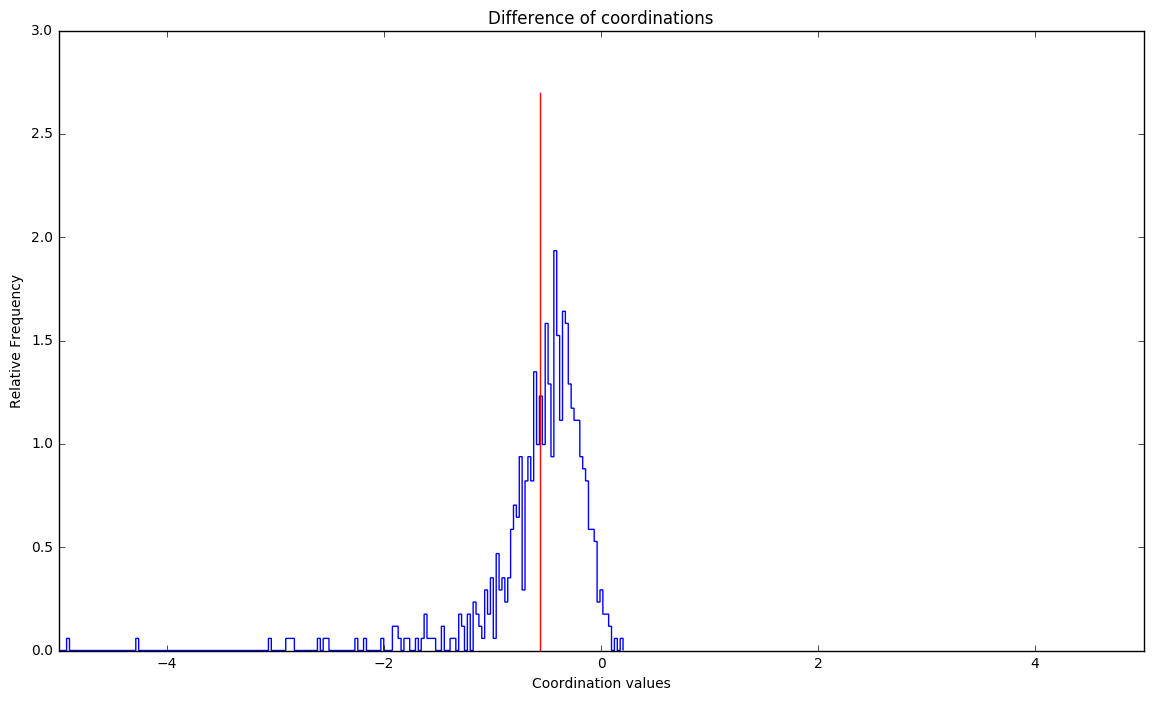

In [59]:
# let's plot D to see how it is distributed
# dictionary for colors
plt.figure(figsize=(14,8))
mean = np.mean(D['all'])
plt.axvline(x=mean, ymin=0, ymax=0.9, label='mean', color='red')
n, bins, patches = plt.hist(D['all'], 200, histtype='step', normed=True, color='blue')
plt.axis([-5, 5, 0, 3])
plt.title("Difference of coordinations")
plt.xlabel("Coordination values")
plt.ylabel("Relative Frequency")
#labels = ['Backchannel (b)', 'Appreciation (ba)', 'Conventional-closing (fc)', 'Conventional-opening (fp)']
#plt.legend(labels, title="Turn-taking utterance is")

## Influence of demographic variables on coordination

** Question 5 (25 points)** 

Pick a demographic variable (e.g. age, gender, education) and test if there is a significant difference in coordination. Plot the coordination values and provide a statistical analysis of your result.

Answer:
We decided to check the D statistic for male-male conversations and female-female conversations separately. The results show that female-female conversations have bigger values than male-male, reflected both in the mode and the mean. The difference is significant with p value equal to 2.7168e-07

*Provide analysis of results*

In [76]:
# Plot results
# first let's gather the data to plot
D_gender = compute_D(corpus=corpus, markers=markers, condition_tester={'female': lambda t: 
                                                                t.from_caller_sex == t.to_caller_sex and 
                                                               t.from_caller_sex == 'FEMALE',
                                                                'male': lambda t:
                                                                t.from_caller_sex == t.to_caller_sex and
                                                               t.from_caller_sex == 'MALE'})

transcript 645


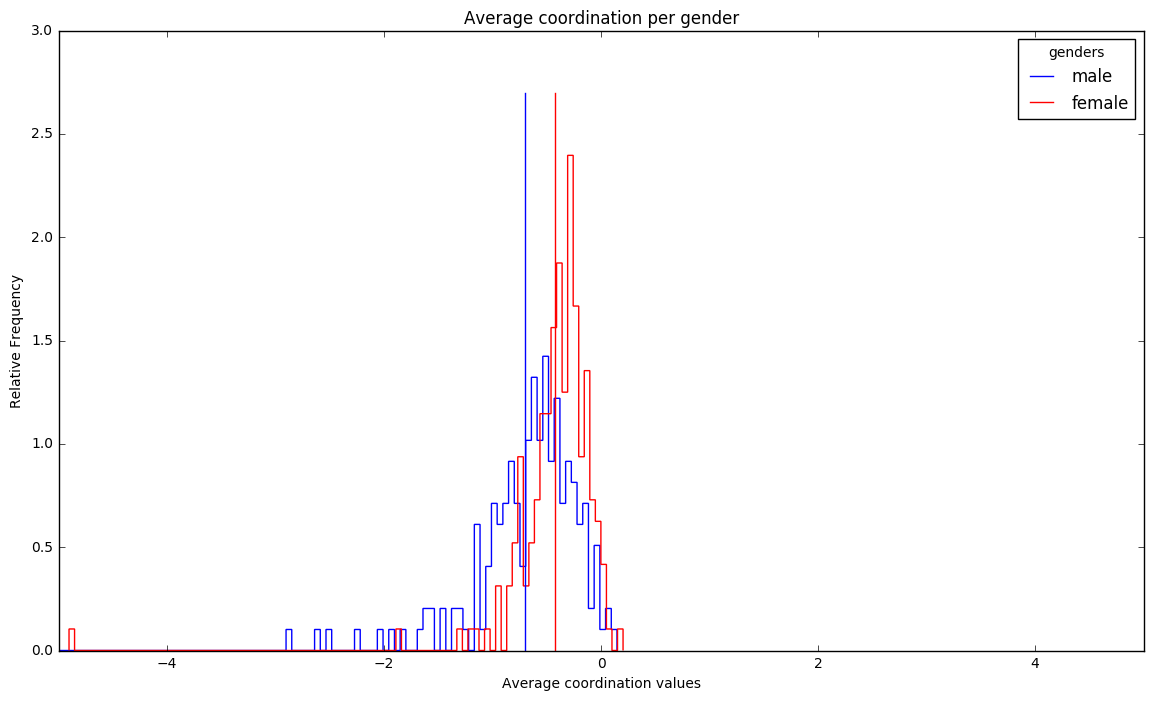

In [84]:
# and now plot it
genders = D_gender.keys()
cdict = dict(zip(genders, ['blue','red']))

plt.figure(figsize=(14,8))
for var in genders:
    mean = np.mean(D_gender[var])
    plt.axvline(x=mean, ymin=0, ymax=0.9, label=str(var), color=cdict[var])
    n, bins, patches = plt.hist(D_gender[var], 100, histtype='step', normed=True, color=cdict[var])
plt.axis([-5, 5, 0, 3])
plt.title("Average coordination per gender")
plt.xlabel("Average coordination values")
plt.ylabel("Relative Frequency")
plt.legend(genders, title="genders")

In [86]:
# statistical tests supporting your results
# data
import scipy.stats
data_f = D_gender['female']
data_m = D_gender['male']

# print mean and sample size of the data
print "Female-female conversations:\t mean coordination: %f\t sample size: %i" % (np.mean(data_f), len(data_f))
print "Male-male conversations:\t mean coordination: %f\t sample size: %i\n" % (np.mean(data_m), len(data_m))

# print results for t-test
print "\nt-test assuming unequal variance: T: %f\t p-value :%.4e" % scipy.stats.ttest_ind(data_f, data_m, equal_var=False)

Female-female conversations:	 mean coordination: -0.423287	 sample size: 188
Male-male conversations:	 mean coordination: -0.701247	 sample size: 187


t-test assuming unequal variance: T: 5.247576	 p-value :2.7168e-07


** Bonus question (10 points)**

Your own question.

We checked if the D statistic is different for younger vs older users. For that we split the population by the median over birth year (1956).
For this split, the distributions are very similar and we didn't find a significant difference (p = 7.8168e-01)

In [99]:
# first we gather the data
D_age = compute_D(corpus=corpus, markers=markers, 
                        condition_tester={'young': lambda t: 
                                          t.from_caller_birth_year.year<1956 and t.to_caller_birth_year.year<1956, 
                                          'old': lambda t:
                                          t.from_caller_birth_year.year>=1956 and t.to_caller_birth_year.year>=1956
                                         })

transcript 645


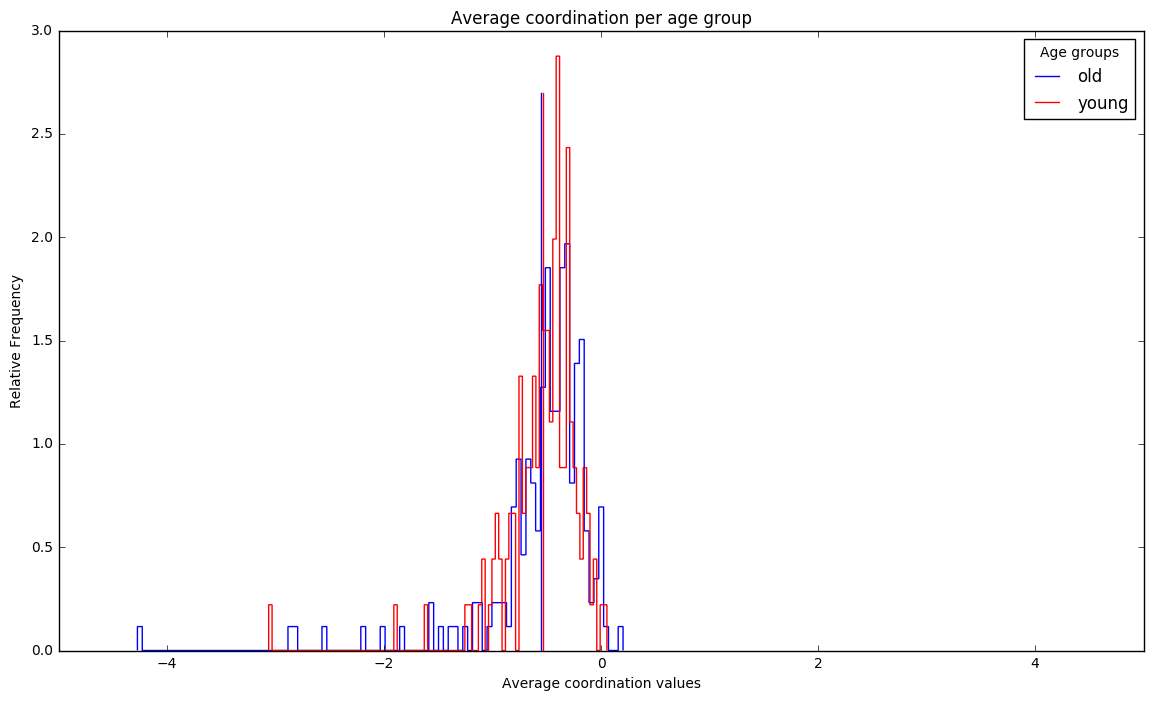

In [102]:
# and now plot it
age_groups = D_age.keys()
cdict = dict(zip(age_groups, ['blue','red']))

plt.figure(figsize=(14,8))
for var in age_groups:
    mean = np.mean(D_age[var])
    plt.axvline(x=mean, ymin=0, ymax=0.9, label=str(var), color=cdict[var])
    n, bins, patches = plt.hist(D_age[var], 100, histtype='step', normed=True, color=cdict[var])
plt.axis([-5, 5, 0, 3])
plt.title("Average coordination per age group")
plt.xlabel("Average coordination values")
plt.ylabel("Relative Frequency")
plt.legend(age_groups, title="Age groups")

In [103]:
# statistical tests supporting your results
# data
import scipy.stats
data_y = D_age['young']
data_o = D_age['old']

# print mean and sample size of the data
print "young-young conversations:\t mean coordination: %f\t sample size: %i" % (np.mean(data_y), len(data_y))
print "old-old conversations:\t mean coordination: %f\t sample size: %i\n" % (np.mean(data_o), len(data_o))

# print results for t-test
print "\nt-test assuming unequal variance: T: %f\t p-value :%.4e" % scipy.stats.ttest_ind(data_y, data_o, equal_var=False)

young-young conversations:	 mean coordination: -0.538279	 sample size: 145
old-old conversations:	 mean coordination: -0.551741	 sample size: 193


t-test assuming unequal variance: T: 0.277359	 p-value :7.8168e-01
